# Opdracht Lectoraat Energietransitie

## 1. Business Understanding
Doel: beste fit te maken voor de `thermal inertia (tau)[h]` for each of 23 Assendorp homes.

* Pandas dataframe with learned thermal inertia per home per cooling period; per row: 
    ```
    home_id, 
    starttime, endtime, 
    start_temp_in__degC, end_temp_in__degC, 
    start_temp_out_e__degC, end_temp_out__degC, 
    tau__h
    ```
* Pandas dataframe with average thermal inertia per home per ISO calendar week;
* Visualize temporal variation/trends/patterns per home per ISO calendar week;
* Visualize similarities/difference amongst homes & your assessment;
* Your code to learn thermal inertia for all suitable cooling periods for all 23 homes monitored
  * Preferably as a Pull Request in GitHub from a fork of our repository
* Bonus / Additional challenge? Check/ improve pre-processing on raw data
  * Add time-series based outlier detection & filtering (e.g. based on tsmoothie?)
  * Improved KNMI wheather data
    * Faster geospatial interpolation
    * Proper handling of transition from summer to winter time


## 2. Data Understanding

### 2.1. Libraries importeren
Een snelle zoektocht duidt aan dat PARQUET-bestanden een soort geoptimaliseerde JSON-bestanden zijn (zie [Apache Parquet](https://parquet.apache.org/)). Pandas heeft ook [ondersteuning](https://pandas.pydata.org/pandas-docs/version/0.21/io.html#io-parquet) voor Parquet-bestanden met de `pd.read_parquet(..., engine='pyarrow')` functie:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.optimize import minimize

### 2.2. Properties
De `read_parquet(...)` functie geeft een `DataFrame` terug. Door een snelle `df.info()` en `df.head()` te doen, zien we het volgende:

In [4]:
house = 803422
props_df = pd.read_parquet(f"data/raw-properties/{house}_raw_properties.parquet", engine='pyarrow')
props_df.info()
props_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41415 entries, (803422, 'DSMR-P1-gateway-TinTsTr', Timestamp('2021-12-21 22:49:33+0100', tz='Europe/Amsterdam')) to (803422, 'DSMR-P1-gateway-TinTsTr', Timestamp('2022-03-16 19:45:16+0100', tz='Europe/Amsterdam'))
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   e_ret_hi_cum__kWh        24165 non-null  float64
 1   e_ret_lo_cum__kWh        24165 non-null  float64
 2   e_timestamp__YYMMDDhhmX  41415 non-null  object 
 3   e_use_hi_cum__kWh        24165 non-null  float64
 4   e_use_lo_cum__kWh        24165 non-null  float64
 5   g_timestamp__YYMMDDhhmX  41415 non-null  object 
 6   g_use_cum__m3            24165 non-null  float64
 7   temp_in__degC            17250 non-null  float32
dtypes: float32(1), float64(5), object(2)
memory usage: 3.9+ MB


property                                                  e_ret_hi_cum__kWh  \
id     source                  timestamp                                      
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00                0.0   
                               2021-12-21 22:54:33+01:00                0.0   
                               2021-12-21 22:59:33+01:00                0.0   
                               2021-12-21 23:04:33+01:00                0.0   
                               2021-12-21 23:09:33+01:00                0.0   

property                                                  e_ret_lo_cum__kWh  \
id     source                  timestamp                                      
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00                0.0   
                               2021-12-21 22:54:33+01:00                0.0   
                               2021-12-21 22:59:33+01:00                0.0   
                               2021-12-21 23:04:33+01:00                0.0   
                               2021-12-21 23:09:33+01:00                0.0   

property                                                 e_timestamp__YYMMDDhhmX  \
id     source                  timestamp                                           
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00           211221224926W   
                               2021-12-21 22:54:33+01:00           211221225426W   
                               2021-12-21 22:59:33+01:00           211221225926W   
                               2021-12-21 23:04:33+01:00           211221230426W   
                               2021-12-21 23:09:33+01:00           211221230926W   

property                                                  e_use_hi_cum__kWh  \
id     source                  timestamp                                      
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00           9750.748   
                               2021-12-21 22:54:33+01:00           9750.773   
                               2021-12-21 22:59:33+01:00           9750.800   
                               2021-12-21 23:04:33+01:00           9750.804   
                               2021-12-21 23:09:33+01:00           9750.804   

property                                                  e_use_lo_cum__kWh  \
id     source                  timestamp                                      
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00           6427.236   
                               2021-12-21 22:54:33+01:00           6427.236   
                               2021-12-21 22:59:33+01:00           6427.236   
                               2021-12-21 23:04:33+01:00           6427.260   
                               2021-12-21 23:09:33+01:00           6427.288   

property                                                 g_timestamp__YYMMDDhhmX  \
id     source                  timestamp                                           
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00           211221220000W   
                               2021-12-21 22:54:33+01:00           211221220000W   
                               2021-12-21 22:59:33+01:00           211221220000W   
                               2021-12-21 23:04:33+01:00           211221230000W   
                               2021-12-21 23:09:33+01:00           211221230000W   

property                                                  g_use_cum__m3  \
id     source                  timestamp                                  
803422 DSMR-P1-gateway-TinTsTr 2021-12-21 22:49:33+01:00       6633.083   
                               2021-12-21 22:54:33+01:00       6633.083   
                               2021-12-21 22:59:33+01:00       6633.083   
                               2021-12-21 23:04:33+01:00       6633.090   
                               2021-12-21 23:09:33+01:00       6633.090   

property                                                  temp_in__degC  
id    

Dit lijkt erg op de tabel:

|category |symbol|variable|Description|unit|API
|-        |-     |-         |-          |-|-
|indoor comfort|$T_{set}$|`temp_set__degC`|thermostat setpoint|$°C$|
||$T_{in}$|`temp_in__degC`|indoor temperature|$°C$|
|ventilation|$CO_{2}$|`co2__ppm`|Indoor CO2 concentration|$ppm$
||$RH$|`rel_humidity__0`|relative indoor humidity|-|
|occupancy|$Occ$|`presence__dBm_csv`|Occupancy|$[dBm]$|
|installation|$T_{sup}$|`temp_sup__degC`, `temp1__degC`/`temp2__degC`|hydronic supply temperature|$°C$|
||$T_{ret}$|`temp_ret__degC`, `temp2__degC`/`temp1__degC`|hydronic return temperature|$°C$|
||$CH$|`ch__bool`|boiler is heating for home heating|$bool$|
||$DHW$|`dhw__bool`|boiler is heating for warm water|$bool$|
||$MOD$|`mod__0`|relative modulation level|-||
|energy|$E$|`e_use_lo_cum__kWh`, `e_use_hi_cum__kWh`,`e_ret_lo_cum__kWh`, `e_ret_hi_cum__kWh`|electricity obtained  from & returned to the grid (high & low tarrif)|$kWh$|Enelogic
||$G$|`g_use_cum__m3`|natural gas used|$m^{3}$|
|weather|$T_{out}$|`temp_out__degC`|outdoor temperature|$°C$|KNMI
||$W$|`wind__m_s_1`|wind speed|$m/s$
||$GHI$|`ghi__W_m_2`|global horizontal irradiance|$W/m^{2}$


### 2.3. Measurements

In [35]:
measure_df = pd.read_csv(f"data/raw-measurements/{house}_raw_measurements.csv", engine='pyarrow')
measure_df.info()
measure_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186405 entries, 0 to 186404
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype             
---  ------       --------------   -----             
 0   id           186405 non-null  int64             
 1   device_name  186405 non-null  object            
 2   source       186405 non-null  object            
 3   timestamp    186405 non-null  datetime64[s, UTC]
 4   property     186405 non-null  object            
 5   value        186405 non-null  object            
 6   unit         138075 non-null  object            
dtypes: datetime64[s, UTC](1), int64(1), object(5)
memory usage: 10.0+ MB


,id,device_name,source,timestamp,property,value,unit
0,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_ret_hi_cum__kWh,0.000,kWh
1,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_ret_lo_cum__kWh,0.000,kWh
2,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_timestamp__YYMMDDhhmX,211221224926W,None
3,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_use_hi_cum__kWh,9750.748,kWh
4,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_use_lo_cum__kWh,6427.236,kWh


<Axes: xlabel='timestamp'>

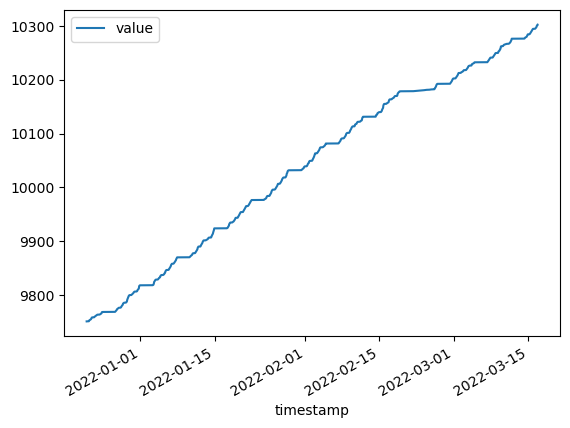

In [36]:
plot_df = measure_df
plot_df = plot_df[plot_df['property'] == 'e_use_hi_cum__kWh'].copy()
# plot_df = plot_df[plot_df['value'].str.isdecimal()]
plot_df.head()
plot_df['value'] =  plot_df['value'].astype(float)
plot_df.plot(x='timestamp', y='value')

# 3. Data Preparation
## 3.1. Zorgen dat de juiste datatypes gebruikt worden

In [69]:
#measure_df['value'] = measure_df['value'].astype(float)
#measure_df['datum'] = measure_df['timestamp'].astype()
measure_df['timestamp'] = pd.to_datetime(measure_df['timestamp'])

measure_df

,id,device_name,source,timestamp,property,value,unit
0,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_ret_hi_cum__kWh,0.000,kWh
1,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_ret_lo_cum__kWh,0.000,kWh
2,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_timestamp__YYMMDDhhmX,211221224926W,None
3,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_use_hi_cum__kWh,9750.748,kWh
4,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2021-12-21 21:49:33+00:00,e_use_lo_cum__kWh,6427.236,kWh
...,...,...,...,...,...,...,...
186400,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2022-03-16 18:45:16+00:00,e_timestamp__YYMMDDhhmX,220316194520W,None
186401,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2022-03-16 18:45:16+00:00,e_use_hi_cum__kWh,10302.506,kWh
186402,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2022-03-16 18:45:16+00:00,e_use_lo_cum__kWh,6726.139,kWh
186403,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,2022-03-16 18:45:16+00:00,g_timestamp__YYMMDDhhmX,220316190000W,None


## 3.2. Index & Resample 

In [77]:
# Pak elke 10 minuten

resampled_measure_df = measure_df.copy()

resampled_measure_df = resampled_measure_df[resampled_measure_df['property'].str.contains("timestamp").__invert__()]
resampled_measure_df = resampled_measure_df[resampled_measure_df['property'].str.contains("kWh").__invert__()]
resampled_measure_df = resampled_measure_df[resampled_measure_df['property'].str.contains("g_use_cum").__invert__()]
resampled_measure_df['value'] = resampled_measure_df['value'].astype(float)


resampled_measure_df = resampled_measure_df.set_index('timestamp')

resampled_measure_df = resampled_measure_df.groupby(['id', 'device_name', 'source', 'property', 'unit'])
resampled_measure_df = resampled_measure_df.resample('10min').mean()
resampled_measure_df = resampled_measure_df.reset_index()

resampled_measure_df.head()

,id,device_name,source,property,unit,timestamp,value
0,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,temp_in__degC,°C,2022-01-15 09:10:00+00:00,19.790
1,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,temp_in__degC,°C,2022-01-15 09:20:00+00:00,18.905
2,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,temp_in__degC,°C,2022-01-15 09:30:00+00:00,18.715
3,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,temp_in__degC,°C,2022-01-15 09:40:00+00:00,18.515
4,803422,TWOMES-D3C410,DSMR-P1-gateway-TinTsTr,temp_in__degC,°C,2022-01-15 09:50:00+00:00,18.355


In [78]:
# # Pivot op de tijd

pivoted_measure_df = resampled_measure_df.pivot(index='timestamp', columns='property', values='value')

pivoted_measure_df['temp_in__degC'] = pivoted_measure_df['temp_in__degC'].interpolate()

pivoted_measure_df.head()

property,temp_in__degC
timestamp,
2022-01-15 09:10:00+00:00,19.790
2022-01-15 09:20:00+00:00,18.905
2022-01-15 09:30:00+00:00,18.715
2022-01-15 09:40:00+00:00,18.515
2022-01-15 09:50:00+00:00,18.355


## 3.3. Gevoelstemperatuur

In [79]:
def gevoelsTemperatuur(row):
    temp = row['temp_out__degC']
    wind = row['wind__m_s_1']

    return temp - (2/3 * wind)


pivoted_measure_df['T_out'] = pivoted_measure_df.apply(gevoelsTemperatuur, axis=1)

KeyError: 'temp_out__degC'

# 4. Modeling

In [9]:
def model(tau:float, df:pd.DataFrame, T_in_at_start:float) -> pd.Series:
    """Note: assumes tau in hours.
       Please make sure that the data has a small time interval, otherwise inaccuracies will occur."""

    # Convert tau from hours to seconds
    tau = tau * 3600

    # Calculate the time difference in seconds (assumes constant interval)
    times = df.index
    timediff = (times[1] - times[0]).seconds

    # Initial temperature gets copied in for the first record
    T = [T_in_at_start]

    # Then we loop over all other steps
    for timestamp in times[1:]:

        # Get the relevant data
        T_in = T[-1]
        T_out = df.loc[timestamp, 'T_out']

        # The equation that does all the work
        T_change = -(T_in - T_out) * timediff / tau

        # Save to array
        T.append(T_in + T_change)

    return pd.Series(data=T, index=times, name='T_in')

# vergelijk de gemeten binnentemperatuur (temp_in__degC) met de hierboven gegeven voorspellingsmodel


binnentemperatuur = measure_df[measure_df['property'] == 'temp_in__degC'].copy()
binnentemperatuur['value'] = binnentemperatuur['value'].astype(float)
binnentemperatuur['datum'] = binnentemperatuur['timestamp'].astype(str)
binnentemperatuur['tijd'] = binnentemperatuur['timestamp'].dt.strftime("%H:%M:%S")

# Datum als index
binnentemperatuur.set_index('datum')

# Pak de nacht van 15 januari 2022
dt_start = pd.Timestamp('2022-01-15T19:00:00', tz='UTC')
dt_end = pd.Timestamp('2022-01-16T08:00:00', tz='UTC')

binnentemperatuur = binnentemperatuur[binnentemperatuur['timestamp'] > dt_start]
binnentemperatuur = binnentemperatuur[binnentemperatuur['timestamp'] < dt_end]




binnentemperatuur['T_out'] = binnentemperatuur.apply(gevoelsTemperatuur, axis=1)


def MSE(y1, y2) -> float:
    return sum((y1 - y2)**2) / len(y1)

# Tau is het aantal uur dat het duurt voor het verhalveren van de temperatuur
def cost_function(tau: float, df: pd.DataFrame, T_in_at_start: float):
    y_model = model(tau, df, T_in_at_start)

    return MSE(y_model, y_target)


minimize(cost_function, 0, args=())

binnentemperatuur.plot(x='tijd', y='value', xlabel='Tijd', ylabel='Temperatuur (°C)', title='Gemeten binnentemperatuur', rot=45)

KeyError: 'temp_out__degC'